In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

### %tensorflow_version 2.x only works in colab
try:
  %tensorflow_version 2.x
except Exception:
  pass

  
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# mpl.rcParams['figure.figsize'] = (6, 6)
mpl.rcParams['axes.grid'] = False

import os
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from sklearn.model_selection import train_test_split

TensorFlow 2.x selected.


Using TensorFlow backend.


Downloading and preprocessing dataset code cells are from this link:

https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb#scrollTo=wKWTYkaRVzjt

In [2]:
!echo "Downloading 101_Object_Categories for image notebooks"
!curl -L -o 101_ObjectCategories.tar.gz --progress-bar http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls

######################################################################## 100.0%
101_ObjectCategories  sample_data


deleting some categories to reduce the size of the dataset.

In [3]:
root = '101_ObjectCategories'

exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces', 'watch', 'hawksbill', 'bonsai', 'car_side', 'brain', 'chandelier', 'Leopards', 'ketch']

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

# counting the number of classes
num_classes = len(categories)
print('Number of classes: ', num_classes)

['101_ObjectCategories/anchor', '101_ObjectCategories/llama', '101_ObjectCategories/barrel', '101_ObjectCategories/revolver', '101_ObjectCategories/garfield', '101_ObjectCategories/schooner', '101_ObjectCategories/flamingo', '101_ObjectCategories/pagoda', '101_ObjectCategories/sea_horse', '101_ObjectCategories/headphone', '101_ObjectCategories/ferry', '101_ObjectCategories/panda', '101_ObjectCategories/cup', '101_ObjectCategories/inline_skate', '101_ObjectCategories/emu', '101_ObjectCategories/minaret', '101_ObjectCategories/gerenuk', '101_ObjectCategories/lobster', '101_ObjectCategories/dragonfly', '101_ObjectCategories/water_lilly', '101_ObjectCategories/euphonium', '101_ObjectCategories/buddha', '101_ObjectCategories/mandolin', '101_ObjectCategories/laptop', '101_ObjectCategories/rhino', '101_ObjectCategories/crocodile_head', '101_ObjectCategories/accordion', '101_ObjectCategories/elephant', '101_ObjectCategories/camera', '101_ObjectCategories/platypus', '101_ObjectCategories/menora

In [0]:
def get_image(path): # a path instance = '101_ObjectCategories/metronome/image_0008.jpg'
    img = image.load_img(path, target_size=(224, 224))  # load image and resize it target_size (type of img = PIL.JpegImagePlugin.JpegImageFile)
    x = image.img_to_array(img) ## cast to numpy array with shape = (224, 224, 3)
    x = np.expand_dims(x, axis=0) ## shape = (1, 224, 224, 3)
    x = preprocess_input(x) # preprocess_input subtracts the mean RGB channels of the imagenet dataset.
    return img, x

In [5]:
# counting number of images
n = 0
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    n += len(images)

print('number of samples: ', n)

number of samples:  5100


In [6]:
datax = np.empty((n, 224,224,3), float) 
datay = np.empty((n), int) 
print(datax.shape)
print(datay.shape)

(5100, 224, 224, 3)
(5100,)


In [0]:
## assigning images and labels to numpy arrays

i = 0
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)

        datax[i] = x[0] ## image
        datay[i] = c    ## label
        i += 1

In [8]:
print(datax[0][0][:3])

## scaling data - Neural Networks work better with values between -1 to 1.
datax = datax.astype('float32') / 255.

print(datax[0][0][:3])

[[  25.06099701  -33.77899933 -117.68000031]
 [  18.06099701  -40.77899933 -123.68000031]
 [  20.06099701  -38.77899933 -122.68000031]]
[[ 0.09827842 -0.13246666 -0.46149018]
 [ 0.07082744 -0.15991764 -0.4850196 ]
 [ 0.07867058 -0.1520745  -0.48109803]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1
101_ObjectCategories/llama


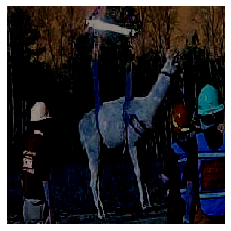

In [9]:
print(datay[100])
print(categories[datay[100]])
plt.imshow(datax[100])
plt.axis('off')
plt.show()

In [10]:
## splitting dataset to train set and test set

x_train, x_test, y_train, y_test = train_test_split(datax, datay, test_size=0.15, random_state=42)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4335, 224, 224, 3)
(4335,)
(765, 224, 224, 3)
(765,)


In [11]:
## creating tensor datasets
print(type(x_train))
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
print(type(train_dataset))
print(train_dataset)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

<class 'numpy.ndarray'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<TensorSliceDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>


In [12]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


print(type(train_dataset))
print(train_dataset)

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>


In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(224,224,3)), ## shape of input image
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),

  tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  tf.keras.layers.Dropout(0.25),
  

  tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),

  tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5), 
  tf.keras.layers.Dense(num_classes) ## softmax activation will be added in compile time
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0

In [0]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), ## from_logits=True does the work of softmax or sigmoid in classification 
              optimizer='adam', ## Adam optimizer
              metrics=['accuracy'])

In [16]:
epochs = 12
model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

Train for 68 steps, validate for 12 steps
Epoch 1/12
68/68 [==============================] - 22s 318ms/step - loss: 4.7889 - accuracy: 0.0298 - val_loss: 4.4072 - val_accuracy: 0.0562
Epoch 2/12
68/68 [==============================] - 11s 167ms/step - loss: 4.2341 - accuracy: 0.0768 - val_loss: 4.1090 - val_accuracy: 0.0928
Epoch 3/12
68/68 [==============================] - 10s 149ms/step - loss: 3.8772 - accuracy: 0.1361 - val_loss: 3.8264 - val_accuracy: 0.1765
Epoch 4/12
68/68 [==============================] - 10s 149ms/step - loss: 3.4933 - accuracy: 0.2138 - val_loss: 3.5169 - val_accuracy: 0.2105
Epoch 5/12
68/68 [==============================] - 10s 151ms/step - loss: 3.0292 - accuracy: 0.2927 - val_loss: 3.2832 - val_accuracy: 0.2654
Epoch 6/12
68/68 [==============================] - 10s 152ms/step - loss: 2.6652 - accuracy: 0.3656 - val_loss: 3.1740 - val_accuracy: 0.3033
Epoch 7/12
68/68 [==============================] - 10s 150ms/step - loss: 2.3473 - accuracy: 0.4263

The Accuracy is 68% for train set and 37% for test set(Overfitting!).

It is enough for purpose. However you can improve the performance of the network by applying data augmentation or trying more complex architectures like ResNet and etc.

## FGSM: Fast Gradient Sign Method
Now we want to attack the trained network!

In [0]:
def create_adversarial_pattern(input_image, input_label):
    loss_object = tf.keras.losses.CategoricalCrossentropy()

    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = probability_model(input_image)
        loss = loss_object(input_label, prediction)
    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

28
Category:  101_ObjectCategories/camera


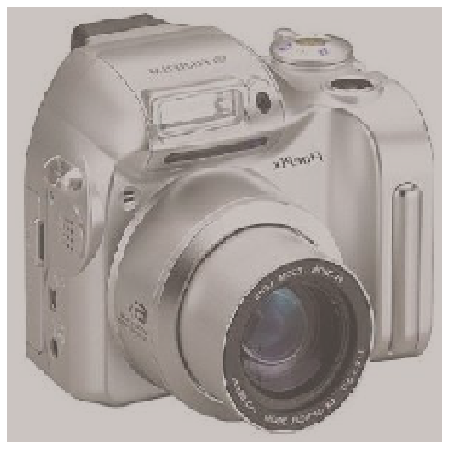

In [22]:
mpl.rcParams['figure.figsize'] = (8, 8)

imgNo = 1600
print(datay[imgNo])
print('Category: ', categories[datay[imgNo]])
plt.imshow(datax[imgNo] * 0.5 + 0.5) # scaling data to [0-1]
plt.axis('off')
plt.show()

In [0]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax() ## adding softmax to the model to see outputs as probability
])

In [24]:
img = datax[imgNo]
img.shape

(224, 224, 3)

In [25]:
result = probability_model(np.expand_dims(img, axis=0))
result

<tf.Tensor: shape=(1, 89), dtype=float32, numpy=
array([[3.7848564e-05, 6.9195739e-06, 1.1322776e-07, 2.8360753e-07,
        4.3448325e-09, 8.5980998e-04, 2.2073627e-09, 3.4082188e-12,
        1.4912458e-06, 4.3240248e-05, 2.8108095e-04, 1.6837046e-06,
        1.8031578e-05, 1.8229734e-08, 6.4490107e-09, 1.8256483e-09,
        6.8198547e-10, 3.0771539e-09, 3.7710994e-09, 5.4114415e-09,
        1.4726154e-09, 3.6213919e-07, 3.5842546e-10, 1.7682521e-06,
        1.2360697e-07, 1.9928235e-10, 5.9749073e-15, 1.7969942e-04,
        9.9761260e-01, 1.8872839e-08, 6.3021557e-09, 1.9293489e-07,
        1.7652720e-09, 1.3762094e-07, 1.9431747e-08, 6.6864970e-07,
        1.5412732e-08, 1.5529804e-07, 4.5971618e-09, 3.1025307e-09,
        1.8542789e-06, 5.0151161e-08, 2.6751522e-08, 4.2994198e-12,
        2.7792399e-09, 6.9920516e-06, 4.1701645e-05, 1.8053594e-06,
        6.0105344e-06, 8.2305887e-09, 5.6574997e-08, 1.1258846e-13,
        4.8457173e-07, 2.3591906e-10, 1.4090698e-07, 1.9084923e-09,

In [26]:
pred = np.argmax(result)
print(np.max(result))
print(pred)
print(categories[pred])

0.9976126
28
101_ObjectCategories/camera


Model correctly predicted the input images as a camera with high confidence. 99.7% certainty!

Now let's attack the network using this image.

In [27]:
label = pred
label = tf.one_hot(label, result.shape[-1])
print(label.shape)
label = tf.reshape(label, (1, result.shape[-1]))
print(label.shape)

(89,)
(1, 89)


In [0]:
img = tf.convert_to_tensor(np.expand_dims(img, axis=0), dtype=tf.float32) # numpy.ndarray to not tf.Tensor

In [0]:
perturbations = create_adversarial_pattern(img, label)

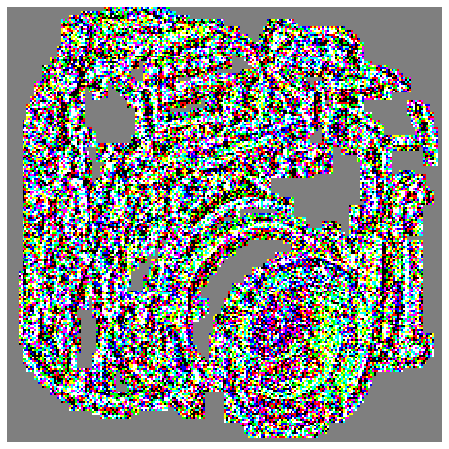

In [30]:
plt.imshow(perturbations[0]*0.5 + 0.5)
plt.axis('off')
plt.show()

We add the above noise to the original image with a coefficient of 0.05. You can try other values for epsilon.

In [0]:
eps = 0.05
adversarial_image = img + eps*perturbations

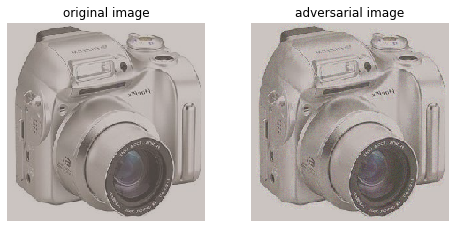

In [32]:
plt.subplot(220 + 1)
plt.imshow(img[0]*0.5 + 0.5)
plt.axis('off')
plt.title('original image')
plt.subplot(220 + 2)
plt.imshow(adversarial_image[0]*0.5 + 0.5)
plt.title('adversarial image')
plt.axis('off')
plt.show()

The images look similar and it is difficult to distinguish between them!

In [33]:
attack_result = probability_model(adversarial_image)
print(attack_result)

tf.Tensor(
[[1.91566069e-05 5.56902978e-06 7.79304514e-08 5.96924849e-07
  3.88298304e-07 6.63754866e-02 3.69176973e-08 3.13510412e-10
  6.14303531e-07 4.16111574e-03 2.32375087e-03 9.66126936e-06
  1.56149017e-05 1.38920086e-07 1.78761269e-07 9.18358865e-08
  5.86062718e-08 8.85265479e-07 3.00058377e-06 7.53062182e-08
  3.87897403e-09 1.39251893e-06 3.18601368e-09 8.62190427e-06
  1.45047352e-07 4.11267154e-09 5.37705947e-12 2.86413298e-04
  9.37879365e-03 1.16635943e-06 6.72434481e-08 1.75236300e-06
  3.14734798e-08 2.96884480e-07 4.20806749e-08 3.51232939e-06
  1.85392025e-06 1.07065455e-06 3.22947287e-08 5.55932367e-08
  7.48278239e-07 9.09778237e-07 2.54283259e-06 6.15909615e-11
  1.10356986e-08 2.89335621e-05 3.35513428e-03 3.16546016e-06
  9.07018511e-06 1.58891709e-07 9.57873226e-07 8.81525647e-13
  5.84445252e-06 1.70078067e-08 6.64117624e-06 2.30680428e-07
  5.46994386e-07 2.21877490e-05 6.62748789e-07 1.41234642e-08
  9.10968721e-01 3.02727123e-08 5.47166756e-10 2.60675373e-

In [34]:
print('Certainty:', np.max(attack_result))
print(attack_pred)
print('Detected category:', categories[attack_pred])

Certainty: 0.9109687
60
Detected category: 101_ObjectCategories/soccer_ball


We fooled the network!

Now it is predicting the camera as a soccer ball with high confidence!! 91% certainty! WOW!!!
